# Machine Learning for Creep Rupture Prediction
This notebook delves into the use of ML techniques to predict the creep rupture life of variations of 2.25Cr1Mo1 Steel. This steel is the focus of this investigation due to its common use in high-temperature and high-pressure applications such as pressure vessels, boilers, etc.

The data used in this investigation is collated from a several sources that have performed vast creep testing on the material in question. The main sources being the Japanese National Institute for Materials Science (NIMS), the British Steelmakers Creep Committee (BSCC), the American Association for Testing and Materials (ASTM), and the European Research Area (ERA).

The data is tabular and has many features, although not all are used as input features in this investigation. The main features are test temperature, stress, sample minimum section size, heat treatment method, tempering temperature, and the component weights of alloying materials.

This notebook is organized as follows. Section 0 imports the data and provides the initial data preprocessing. The subsequent sections demonstrate the implementation of different ML models, including subsections for grid-search and k-fold validation.

It is important to note the inherent variability of creep rupture lifetimes, even between samples that are supposedly identical. Slight microstructural differences may lead to significant changes in rupture times, which explains much of the remaining model inaccuracies.

# 0. Data Import and Preprocessing


In [2]:
#import relevant general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
time_variable = "Time to Rupture (hr)"

## 0.1. Definition of Preprocessing Functions

I tried a few different datasets which did not load properly due to varying encoding types so I wrote the code below to ensure that would not be a problem.

In [4]:

def importDataFast(file):
  # Reading the file considering a few different encodings:
  try:
      df = pd.read_csv(file, encoding='utf-8')
      print("File read using utf-8")
  except UnicodeDecodeError:
      try:
          df = pd.read_csv(file, encoding='latin-1')   #AKA ISO-8859-1
          print("File read using latin-1")
      except UnicodeDecodeError:
          df = pd.read_csv(file, encoding='cp1252')
          print("File read using cp1252")
  return df


This function allows us to input a list of the features we want and return the df with only those. Input the dataframe and a list of the variables to keep.

In [5]:
def chooseVars(df, variables):
  print(f"new dataframe contains these features: {variables}")
  return df[variables]

We can't work with data without a time to rupture, so the code below removes all rows with NaN or a blank String in the Time to Rupture column. The vars variable takes a list of all the variables where we cannot tolerate empty entries.

Below that, we set all possible values to floats and thereafter impute any missing values / non-floats with the mean of the corresponding feature.

In [6]:
def removeNan(df, vars):
  vars_to_check = [time_variable]
  for var in vars:
    if var in df.columns: #checking that the input features exist in the df
      vars_to_check.append(var)

  # Remove rows with NaN or " " in the specified columns.
  for col in vars_to_check:
    df = df[df[col].notna() & (df[col] != " ")]

  return df

#convert all possible values to float, and those which cannot be converted are left as they are.
#this is so that later, when we impute values, we can impute anything that is not numeric.
def setFloat(df):
  def convert_to_float(value):
    try:
        return float(value)
    except:
        return value
    # Apply the conversion function to each element in the DataFrame
  df = df.applymap(convert_to_float)
  return df

#impute missing values (anything not numeric) with the mean of that feature.
#must provide a list of variables to impute.
def impute(df, variables):
  for var in variables:
    df[var] = pd.to_numeric(df[var], errors='coerce')
    # Replace NaN values with the mean of the column
    df[var].fillna(df[var].mean(), inplace=True)

  return df


In [7]:
#create dummy variables for the categorical variables (mainly heat treatment category). Those variables provided as inputs.
def create_dummies(df, categories):
  try:
    df_encoded = pd.get_dummies(df, columns=categories, prefix='Category')
  except:
    print("One or more of the input categories could not be found in the dataframe.")
    return df
  return df_encoded

In [8]:
#Introduce a column of log(t) - this is the variable we will predict, rather than the actual creep rupture values.
#IMPORTANT NOTE: np.log performs the NATURAL logarithm rather than base 10. So to achieve log_10 we can divide by ln(10).
def timeLog(df):
  df["logtime"] = np.log(df[time_variable]) / np.log(10)
  return df

#Z-Scale normalizing.
def Zscale(df):
  from sklearn.preprocessing import StandardScaler

  columns_to_exclude = [time_variable, "logtime", "Reference"]

  # Separate columns to be standardized from those to be excluded
  selected_columns = [col for col in df.columns if col not in columns_to_exclude]
  excluded_columns = [col for col in df.columns if col in columns_to_exclude]

  # Apply Z-scale (standardization) to selected columns
  scaler = StandardScaler()
  df[selected_columns] = scaler.fit_transform(df[selected_columns])

  # Combine the selected and excluded columns to create the final DataFrame
  final_df = pd.concat([df[selected_columns], df[excluded_columns]], axis=1)

  return final_df


#Max-Min Scaler
def MMscale(df):
  from sklearn.preprocessing import MinMaxScaler

  columns_to_exclude = [time_variable, "logtime"]

  # Separate columns to be standardized from those to be excluded
  selected_columns = [col for col in df.columns if col not in columns_to_exclude]
  excluded_columns = [col for col in df.columns if col in columns_to_exclude]

  # Apply Z-scale (standardization) to selected columns
  scaler = MinMaxScaler()
  df[selected_columns] = scaler.fit_transform(df[selected_columns])

  # Combine the selected and excluded columns to create the final DataFrame
  final_df = pd.concat([df[selected_columns], df[excluded_columns]], axis=1)

  return final_df

## 0.2. Implementation of Data Preprocessing

Below we import the dataset and choose the features we want:

In [9]:
file_name = "Creep Data 1.csv"

#here we list the variables we are interested in (over different lines to separate different feature types).
variables = ["Temperature (°C)", "Creep rupture stress (MPa)", "Time to Rupture (hr)",
             "Max Tempering Temperature (°C)", "Heat Treatment Code",
             "Minimum Section Size (mm)",
             "Reference",
             "C (%)", "Si (%)", "Mn (%)", "P (%)", "S (%)", "Cr (%)", "Mo (%)", "Ni (%)", "Cu (%)", "Al (%)", "Sn (%)", "V (%)", "N (%)"]

df1 = importDataFast(file_name)
df2 = chooseVars(df1, variables)

File read using latin-1
new dataframe contains these features: ['Temperature (°C)', 'Creep rupture stress (MPa)', 'Time to Rupture (hr)', 'Max Tempering Temperature (°C)', 'Heat Treatment Code', 'Minimum Section Size (mm)', 'Reference', 'C (%)', 'Si (%)', 'Mn (%)', 'P (%)', 'S (%)', 'Cr (%)', 'Mo (%)', 'Ni (%)', 'Cu (%)', 'Al (%)', 'Sn (%)', 'V (%)', 'N (%)']


Next we perform all the processing of the dataset to remove nan values and impute means for those features with missing values.

In [10]:
#here we remove all the entries with NaN time to rupture, stress, temperature, or heat treatment code.
#we remove those with missing heat treatment code because it is categorical and can't be imputed.
df2 = removeNan(df2, ['Creep rupture stress (MPa)', 'Temperature (°C)', 'Heat Treatment Code'])

#set values to float in case there are entries that may be converted into NaN in the impute function:
df2 = setFloat(df2)

#now we replace the missing values with their averages
features_to_impute = ['Max Tempering Temperature (°C)', 'Minimum Section Size (mm)', 'C (%)', 'Si (%)', 'Mn (%)',
                     'P (%)', 'S (%)', 'Cr (%)', 'Mo (%)', 'Ni (%)', 'N (%)', 'Cu (%)', 'Al (%)', 'Sn (%)', 'V (%)']

df2 = impute(df2, features_to_impute)

#create dummies for the categorical data which in this case is heat treatment type
df2 = create_dummies(df2, ["Heat Treatment Code",]) #"Reference"

#create a new column for the log of rupture times
df2 = timeLog(df2)

#finally reset indices:
df2.reset_index(drop=True, inplace=True)

In [11]:
#overview of the data:
df2

,Temperature (°C),Creep rupture stress (MPa),Time to Rupture (hr),Max Tempering Temperature (°C),Minimum Section Size (mm),Reference,C (%),Si (%),Mn (%),P (%),...,Category_A&T,Category_Ann,Category_Ex Service,Category_N&T,Category_N&T&T,Category_Not Known,Category_PWHT,Category_Q&T,Category_Q&T&T,logtime
0,500.0,294.1,794.5,740.000000,8.00,NIMS No 3B & 50,0.13,0.27,0.49,0.019,...,False,False,False,True,False,False,False,False,False,2.900094
1,500.0,264.7,1567.3,740.000000,8.00,NIMS No 3B & 50,0.13,0.27,0.49,0.019,...,False,False,False,True,False,False,False,False,False,3.195152
2,500.0,215.7,6057.0,740.000000,8.00,NIMS No 3B & 50,0.13,0.27,0.49,0.019,...,False,False,False,True,False,False,False,False,False,3.782258
3,500.0,176.5,17829.6,740.000000,8.00,NIMS No 3B & 50,0.13,0.27,0.49,0.019,...,False,False,False,True,False,False,False,False,False,4.251142
4,500.0,156.9,31692.8,740.000000,8.00,NIMS No 3B & 50,0.13,0.27,0.49,0.019,...,False,False,False,True,False,False,False,False,False,4.500961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,649.0,82.7,142.0,692.366086,25.40,"EPRI Steiner, 1968",0.11,0.26,0.37,0.010,...,False,False,False,False,False,False,False,True,False,2.152288
2000,649.0,41.4,1319.0,692.366086,25.40,"EPRI Steiner, 1968",0.11,0.26,0.37,0.010,...,False,False,False,False,False,False,False,True,False,3.120245
2001,670.0,40.0,2822.0,692.366086,99.06,"EPRI Ripley, 1993",0.00,0.00,0.00,0.000,...,False,False,True,False,False,False,False,False,False,3.450557
2002,700.0,40.0,439.0,692.366086,99.06,"EPRI Ripley, 1993",0.00,0.00,0.00,0.000,...,False,False,True,False,False,False,False,False,False,2.642465


## 0.3 Feature Correlation

In [ ]:
correlation_matrix = df2.drop(["Reference"], axis=1).corr()

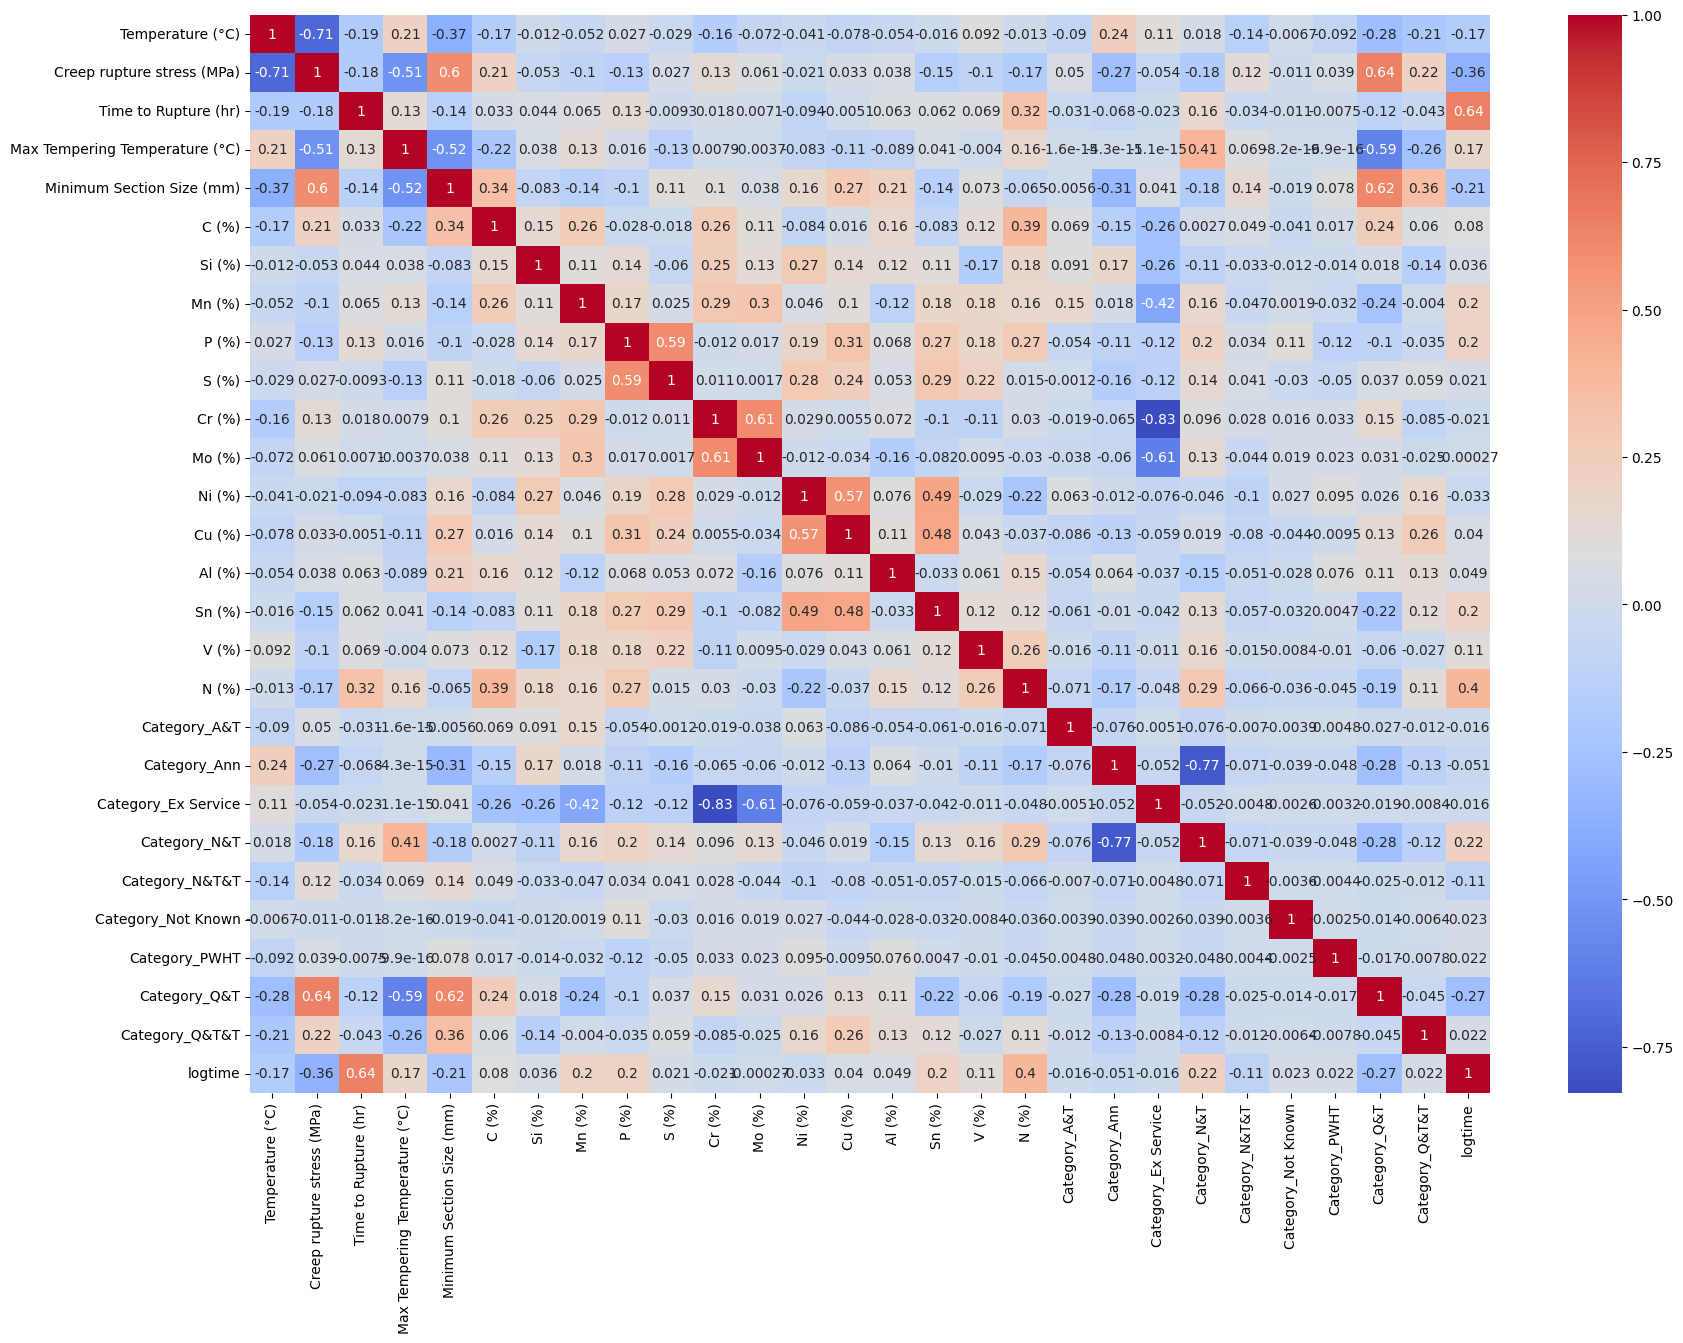

In [ ]:
plt.figure(figsize=(20,14))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

# 1. Random Forests (RF)
Here we create the functions that we'll use for Random Forests training

## 1.1 Function definitions:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def RFtrain(df):
  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  #train/test split:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  #intialize and train model:
  RF_regressor = RandomForestRegressor(n_estimators=100)
  RF_regressor.fit(X_train, y_train)

  #make predictions:
  test_pred = RF_regressor.predict(X_test)
  train_pred = RF_regressor.predict(X_train)

  test_mse = mean_squared_error(y_test,test_pred)
  train_mse = mean_squared_error(y_train,train_pred)
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))

  #plt.scatter(test_pred,y_test, s=4, label=f"MSE: {test_mse}, R^2: {r2_test}")
  #plt.legend()
  #plt.xlabel("predicted log(life)")
  #plt.ylabel("actual log(life)")
  return X_train, X_test, y_test, RF_regressor

## 1.2 Implementing RF:

Below we plot the residuals of predictions, colored by data origin source. Not all sources are shown, because of the specific train/test split.

(2004, 29)


r^2 for test data: 0.8421970026777486
r^2 for training data: 0.9773377829426793
MSE for test data: 0.13574305732411981
MSE for training data: 0.024675268055981033


<ipython-input-85-c76b35e07ceb>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.colorbar().set_ticklabels(pd.unique(ref))


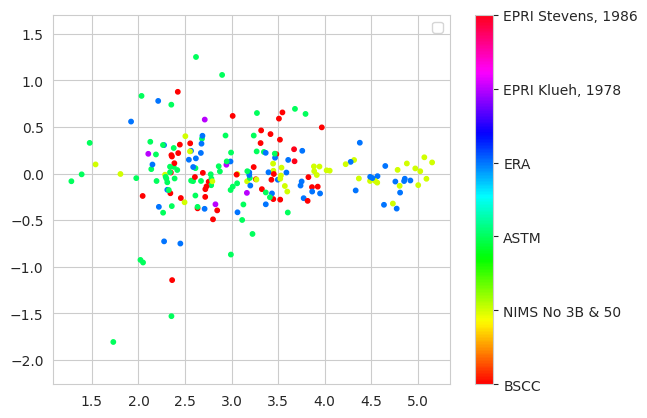

In [ ]:
ref, X_train, rfX,rfY, rfReg = RFtrain(df2)
rfYpred = rfReg.predict(rfX)
#plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
plt.scatter(rfYpred,rfYpred-rfY,s=10, c=pd.factorize(ref)[0], cmap="hsv")
plt.axis("equal")
plt.legend()

plt.colorbar().set_ticklabels(pd.unique(ref))

## 1.3 Grid Search RF

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def gridSearchRF(df):
  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = RandomForestRegressor()

  # Define the hyperparameter grid
  param_grid = {
    'n_estimators': [40, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'log2', 0.2, None],
    #'bootstrap': [True],
    }

  # Instantiate the GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

  # Fit the GridSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_

  # Get the best model and make predictions on the test set
  best_model = grid_search.best_estimator_
  test_pred = best_model.predict(X_test)
  train_pred = best_model.predict(X_train)

  # Evaluate the performance of the best model
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train, train_pred)

  print(f"best params: {best_params}")
  print(f"test r2: {r2_test}")
  print(f"train r2: {r2_train}")

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return best_model

best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
test r2: 0.8720063433592501
train r2: 0.9757327392727728


RandomForestRegressor(n_estimators=300)

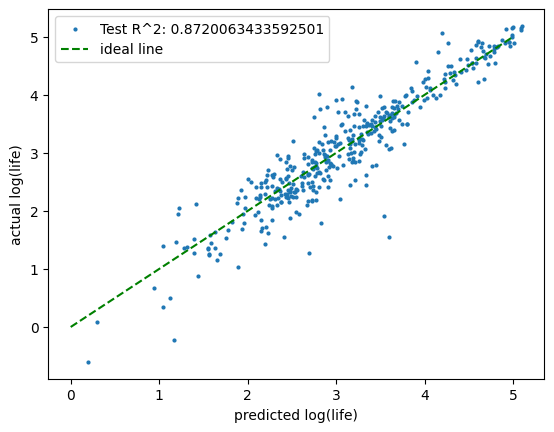

In [ ]:
gridSearchRF(df2)

## 1.4 K-fold validation RF

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X = df2.drop([time_variable, 'logtime', 'Reference'], axis=1)
y = df2['logtime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the number of folds
k_folds = 30

# Create a random forest classifier (replace this with your actual model)
classifier = RandomForestRegressor(n_estimators=200,max_depth=None,min_samples_split=2,min_samples_leaf=1)

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = cross_val_score(classifier, X, y, cv=kf, scoring="r2") # r2 or neg_mean_squared_error

# Print the results for each fold
for i, accuracy in enumerate(cv_results, 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}')

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(cv_results):.4f}')

Fold 1: Accuracy = 0.8768
Fold 2: Accuracy = 0.6664
Fold 3: Accuracy = 0.9132
Fold 4: Accuracy = 0.8392
Fold 5: Accuracy = 0.8790
Fold 6: Accuracy = 0.8471
Fold 7: Accuracy = 0.7821
Fold 8: Accuracy = 0.8469
Fold 9: Accuracy = 0.8617
Fold 10: Accuracy = 0.8325
Fold 11: Accuracy = 0.8641
Fold 12: Accuracy = 0.8822
Fold 13: Accuracy = 0.8872
Fold 14: Accuracy = 0.9116
Fold 15: Accuracy = 0.8505
Fold 16: Accuracy = 0.8895
Fold 17: Accuracy = 0.8353
Fold 18: Accuracy = 0.8786
Fold 19: Accuracy = 0.8899
Fold 20: Accuracy = 0.8849
Fold 21: Accuracy = 0.8449
Fold 22: Accuracy = 0.7953
Fold 23: Accuracy = 0.8790
Fold 24: Accuracy = 0.9129
Fold 25: Accuracy = 0.8416
Fold 26: Accuracy = 0.8193
Fold 27: Accuracy = 0.9110
Fold 28: Accuracy = 0.8962
Fold 29: Accuracy = 0.8818
Fold 30: Accuracy = 0.8466
Average Accuracy: 0.8582


## 1.5 SHAP Feature Selection for RF

Import / install SHAP

In [ ]:
try:
    import shap
    print("Shap is already installed - shap imported.")
except ImportError:
    print("Shap is not installed. Installing...")
    %pip install shap
    print("Shap has been installed and imported.")
    import shap

Shap is not installed. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 12.1 MB/s eta 0:00:00
Shap has been installed and imported.


Initial SHAP analysis

r^2 for test data: 0.8569541657526204
r^2 for training data: 0.9773362132811519
MSE for test data: 0.15153184563598934
MSE for training data: 0.02417731359740797


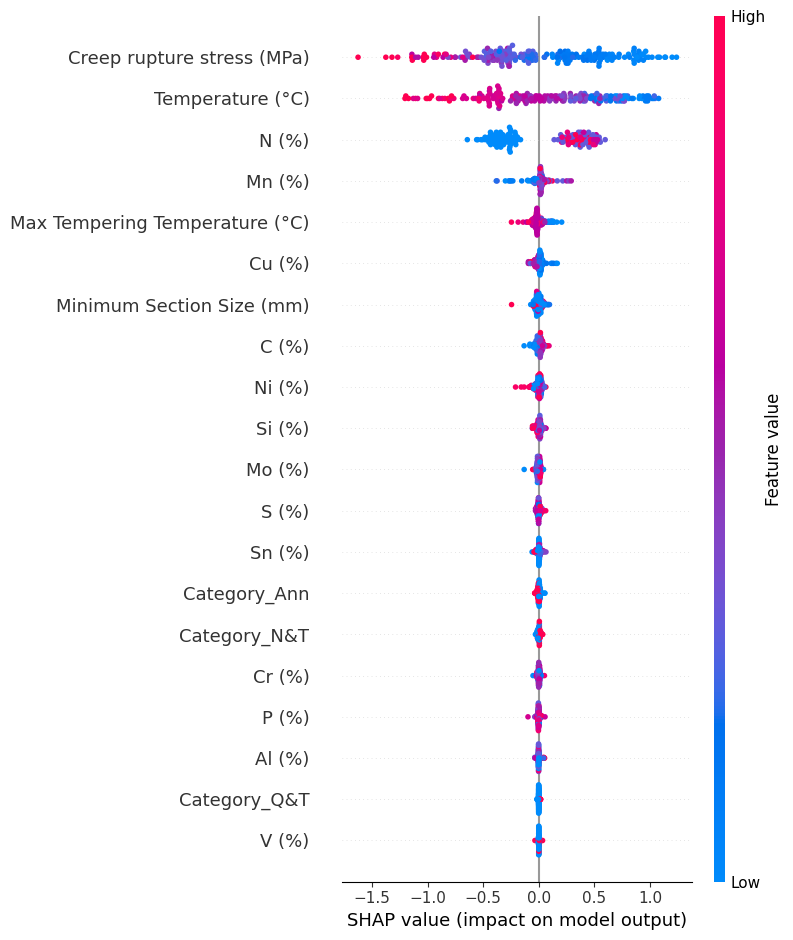

In [ ]:
X_train, X_test, y_test, model = RFtrain(df2)

# Assuming 'model' is the trained model and 'X_test' is the test data
explainer = shap.Explainer(model)
shap_valuesRF = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_valuesRF, X_test)

Below we get the average magnitude of feature importances and sort them in descending order.

In [ ]:
feature_importances = abs(shap_valuesRF).mean(axis=0)

# Create a list of tuples containing feature names and their importances
feature_importance_list = list(zip(X_test.columns, feature_importances))

# Sort the list in descending order based on feature importances
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Print or use the sorted list as needed
print("Feature Importances:")
for feature, importance in feature_importance_list:
    print(f"{feature}: {importance}")

Feature Importances:
Creep rupture stress (MPa): 0.5138871228513683
Temperature (°C): 0.4782044013797581
N (%): 0.3569141171024013
Mn (%): 0.04455386745648065
Max Tempering Temperature (°C): 0.03894142394619911
Cu (%): 0.02314259042265311
Minimum Section Size (mm): 0.02128604331232719
C (%): 0.02086443903545452
Ni (%): 0.02081667498137853
Si (%): 0.014211615810619997
Mo (%): 0.011645752217519477
S (%): 0.009099751997424932
Sn (%): 0.00900209514957391
Category_Ann: 0.00805793336922638
Category_N&T: 0.006840165819313734
Cr (%): 0.0067773690411606045
P (%): 0.006471106392056783
Al (%): 0.0058744349594326475
Category_Q&T: 0.002473604697258539
V (%): 0.0022466742790976375
Category_N&T&T: 0.0011337810313472735
Category_A&T: 0.0010144113508790673
Category_PWHT: 0.0005621524571277463
Category_Q&T&T: 0.00029279863451535756
Category_Not Known: 6.944254264501023e-05
Category_Ex Service: 2.4547464113934076e-05


Text(0, 0.5, 'SHAP Feature Importance Value')

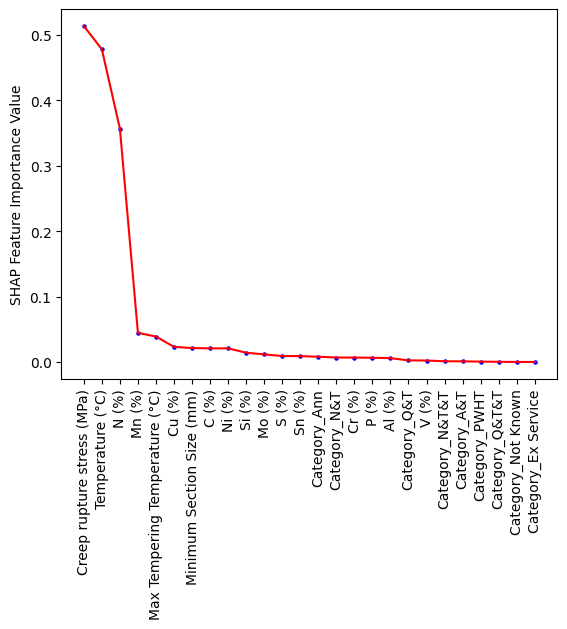

In [ ]:
x = []
y = []

for xi, yi in feature_importance_list:
  x.append(xi)
  y.append(yi)

plt.scatter(x,y, c='blue', s=5)
plt.plot(x,y, c='r')
plt.xticks(rotation=90)
plt.ylabel("SHAP Feature Importance Value")

# 2. Gradient Boosted Decision Trees (GBDT)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def train_GBDT(df):
  X = df.drop(['Time to Rupture (hr)', 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # the hyper parameters below are from the grid search, rather than defaults.
  gbdt_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=3, min_samples_leaf=3)
  gbdt_model.fit(X_train, y_train)

  test_pred = gbdt_model.predict(X_test)
  train_pred = gbdt_model.predict(X_train)
  test_mse = mean_squared_error(y_test,test_pred)
  train_mse = mean_squared_error(y_train,train_pred)
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))


  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return test_pred, y_test, gbdt_model


r^2 for test data: 0.8844149956742271
r^2 for training data: 0.9575425910818504
MSE for test data: 0.12877026565418073
MSE for training data: 0.04475561206054053


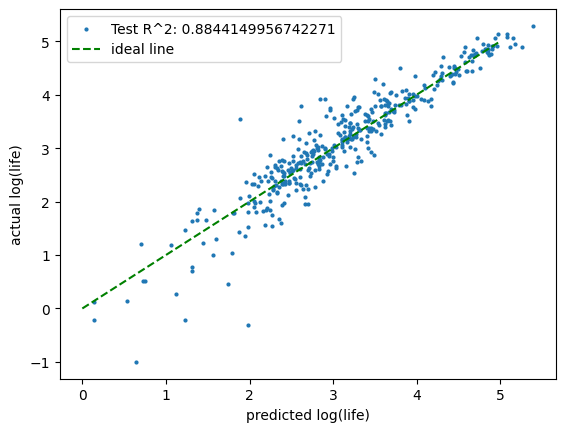

In [ ]:
predictions, y, GBDT = train_GBDT(df2)

## 2.1 Grid Search GBDT
Here Grid Search is applied to find the optimal parameters for the GBDT and RF models.

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def gridSearchGBDT(df):
  X = df.drop([time_variable, 'logtime'], axis=1)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = GradientBoostingRegressor()

  # Define the hyperparameter grid
  param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_leaf': [1, 3, 5]
    }

  # Instantiate the GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

  # Fit the GridSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_

  # Get the best model and make predictions on the test set
  best_model = grid_search.best_estimator_
  test_pred = best_model.predict(X_test)
  train_pred = best_model.predict(X_train)

  # Evaluate the performance of the best model
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train, train_pred)

  print(f"best params: {best_params}")
  print(f"test r2: {r2_test}")
  print(f"train r2: {r2_train}")

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return best_model

best params: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 400}
test r2: 0.8933175046534102
train r2: 0.9728020536466101


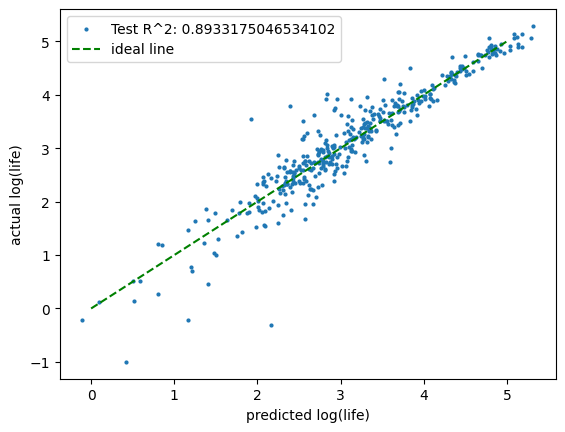

In [ ]:
gridTest = gridSearchGBDT(df2)


## 2.2 K-fold validation GBDT

In [ ]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

X = df2.drop(['Time to Rupture (hr)', 'logtime'], axis=1)
y = df2['logtime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the number of folds
k_folds = 25

# Create a random forest classifier (replace this with your actual model)
classifier = GradientBoostingRegressor(n_estimators=400, learning_rate=0.2, max_depth=3, min_samples_leaf=3)

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = cross_val_score(classifier, X, y, cv=kf, scoring='r2')

# Print the results for each fold
#for i, accuracy in enumerate(cv_results, 1):
    #print(f'Fold {i}: Accuracy = {accuracy:.4f}')

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(cv_results):.4f}')

Average Accuracy: 0.9087


# 3. Extreme Gradient Boosting (XGBoost)

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def train_XGB(df):

  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Create an XGBoost regressor
  xgb_model = XGBRegressor(objective='reg:squarederror')

  # Train the model
  xgb_model.fit(X_train, y_train)

  # Make predictions on the test set
  test_pred = xgb_model.predict(X_test)
  train_pred = xgb_model.predict(X_train)

  #fine MSE
  test_mse = mean_squared_error(y_test, test_pred)
  train_mse = mean_squared_error(y_train,train_pred)

  #find r^2
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")

  return X_test, xgb_model

r^2 for test data: 0.9682583709634284
r^2 for training data: 0.9999020912123451
MSE for test data: 0.029293869880133272
MSE for training data: 9.617669690989254e-05


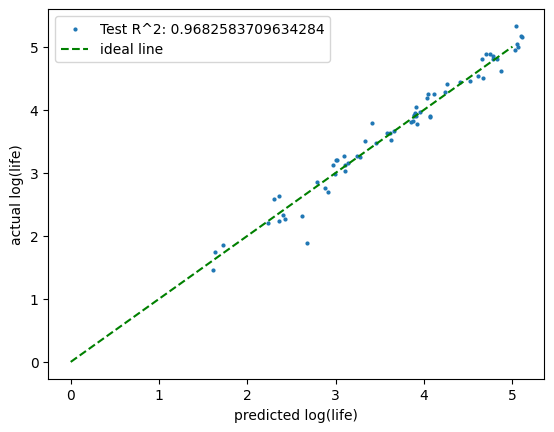

In [ ]:
X_test, XGB = train_XGB(df2)

## 3.1 Grid Search XGBoost

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def gridSearchXGB(df):
  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = XGBRegressor()

  # Define the hyperparameter grid
  param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
    }

  # Instantiate the GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

  # Fit the GridSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_

  # Get the best model and make predictions on the test set
  best_model = grid_search.best_estimator_
  test_pred = best_model.predict(X_test)
  train_pred = best_model.predict(X_train)

  # Evaluate the performance of the best model
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train, train_pred)

  print(f"best params: {best_params}")
  print(f"test r2: {r2_test}")
  print(f"train r2: {r2_train}")

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")

  return best_model

best params: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
test r2: 0.9149789657752594
train r2: 0.9697071211086227


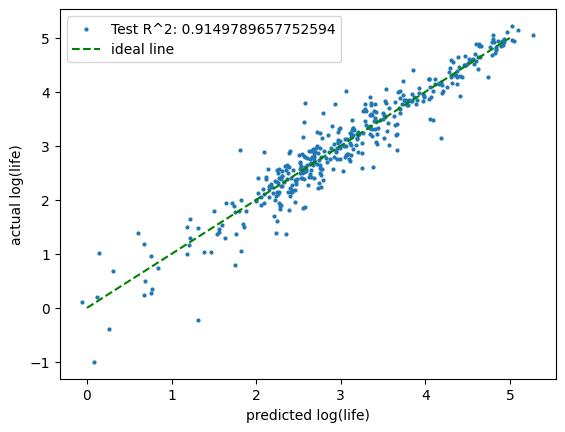

In [ ]:
bestXGB = gridSearchXGB(df2)

## 3.2 K-fold Validation XGBoost

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

X = df2.drop([time_variable, 'logtime', 'Reference'], axis=1)
y = df2['logtime']

# Define the number of folds
k_folds = 25

# Create a random forest classifier (replace this with your actual model)
classifier = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.8)

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = cross_val_score(classifier, X, y, cv=kf, scoring='r2')

# Print the results for each fold
#for i, accuracy in enumerate(cv_results, 1):
    #print(f'Fold {i}: Accuracy = {accuracy:.4f}')

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(cv_results):.4f}')

Average Accuracy: 0.9741


# 4. Support Vector Machines (SVM)
Here we implement support vector regression.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

def train_SVM(df):

  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  X=Zscale(X)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  svm_regressor = SVR(kernel='rbf', C=100, epsilon=0.2)

  # Train the regressor
  svm_regressor.fit(X_train, y_train)

  # Make predictions on the test set
  test_pred = svm_regressor.predict(X_test)
  train_pred = svm_regressor.predict(X_train)

  #assess prediction performance
  test_mse = mean_squared_error(y_test,test_pred)
  train_mse = mean_squared_error(y_train,train_pred)
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))

  plt.scatter(y_test,test_pred, s=4, label=f"Test R^2: {r2_test}", cmap="viridis")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return test_pred, y_test, X_test, svm_regressor


r^2 for test data: 0.910979978867799
r^2 for training data: 0.9656329174265532
MSE for test data: 0.09468826873673566
MSE for training data: 0.03668282690609817


<ipython-input-48-cac56d955a3e>:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,test_pred, s=4, label=f"Test R^2: {r2_test}", cmap="viridis")


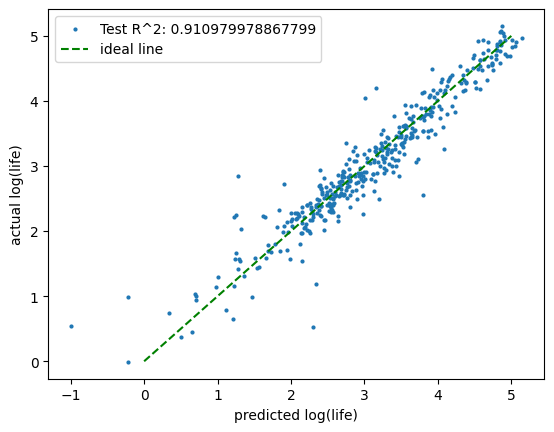

In [ ]:
test_pred, y_test, X_test, SVM = train_SVM(df2)


## 4.1 Grid Search for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

def gridSearchSVM(df):

  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  X = Zscale(X)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  svm_regressor = SVR()

  # Define the hyperparameter grid to search
  param_grid = {
      'C': [0.1, 1, 10, 100],
      'kernel': ['linear', 'rbf', 'poly'],
      'epsilon': [0.1, 0.2, 0.5, 1.0]
  }

  # Create the GridSearchCV object
  grid_search = GridSearchCV(estimator=svm_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

  # Fit the model to the training data
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best estimator
  best_params = grid_search.best_params_
  best_estimator = grid_search.best_estimator_

  # Make predictions on the test set using the best model
  test_pred = best_estimator.predict(X_test)
  train_pred = best_estimator.predict(X_train)

  #assess prediction performance
  test_mse = mean_squared_error(y_test,test_pred)
  train_mse = mean_squared_error(y_train,train_pred)
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print(f"best params: {best_params}")
  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return best_estimator

best params: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
r^2 for test data: 0.9313745831769684
r^2 for training data: 0.9682507631295072
MSE for test data: 0.07420838455028445
MSE for training data: 0.03374710198962031


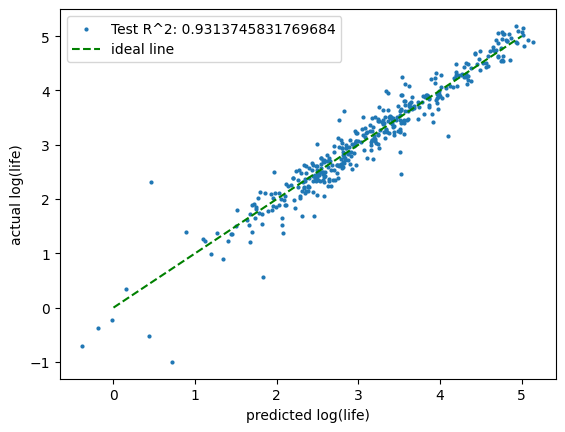

In [ ]:
best_SVM = gridSearchSVM(df2)

## 4.2 K-fold Validation SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

# Prepare the feature matrix X and the target vector y
X = df2.drop([time_variable, 'logtime', 'Reference'], axis=1)
X = Zscale(X)
y = df2['logtime']

# Define the number of folds
k_folds = 25

# Create a random forest classifier (replace this with your actual model)
classifier = SVR(kernel='rbf', C=100, epsilon=0.1)

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = cross_val_score(classifier, X, y, cv=kf, scoring='r2') #neg_mean_squared_error or r2

# Print the results for each fold
for i, accuracy in enumerate(cv_results, 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}')

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(cv_results):.4f}')

Fold 1: Accuracy = 0.9053
Fold 2: Accuracy = 0.9509
Fold 3: Accuracy = 0.9539
Fold 4: Accuracy = 0.9553
Fold 5: Accuracy = 0.9328
Fold 6: Accuracy = 0.9332
Fold 7: Accuracy = 0.9631
Fold 8: Accuracy = 0.9545
Fold 9: Accuracy = 0.9609
Fold 10: Accuracy = 0.9444
Fold 11: Accuracy = 0.8351
Fold 12: Accuracy = 0.8955
Fold 13: Accuracy = 0.9437
Fold 14: Accuracy = 0.9410
Fold 15: Accuracy = 0.9614
Fold 16: Accuracy = 0.9526
Fold 17: Accuracy = 0.9616
Fold 18: Accuracy = 0.9587
Fold 19: Accuracy = 0.9314
Fold 20: Accuracy = 0.9518
Fold 21: Accuracy = 0.9400
Fold 22: Accuracy = 0.9324
Fold 23: Accuracy = 0.9466
Fold 24: Accuracy = 0.9359
Fold 25: Accuracy = 0.8907
Average Accuracy: 0.9373


In [ ]:
df2

,Temperature (°C),Creep rupture stress (MPa),Time to Rupture (hr),Max Tempering Temperature (°C),Minimum Section Size (mm),N (%),Reference,C (%),Si (%),Mn (%),...,Category_A&T,Category_Ann,Category_Ex Service,Category_N&T,Category_N&T&T,Category_Not Known,Category_PWHT,Category_Q&T,Category_Q&T&T,logtime
1344,566.0,100.4,6883.0,692.366086,28.6,0.003791,ERA,0.120,0.21,0.51,...,False,True,False,False,False,False,False,False,False,3.837778
1345,566.0,84.9,24036.0,692.366086,28.6,0.003791,ERA,0.120,0.21,0.51,...,False,True,False,False,False,False,False,False,False,4.380862
1346,566.0,69.5,43615.0,692.366086,28.6,0.003791,ERA,0.120,0.21,0.51,...,False,True,False,False,False,False,False,False,False,4.639636
1347,593.0,61.8,19789.0,692.366086,28.6,0.003791,ERA,0.120,0.21,0.51,...,False,True,False,False,False,False,False,False,False,4.296424
1348,593.0,46.3,45768.0,692.366086,28.6,0.003791,ERA,0.120,0.21,0.51,...,False,True,False,False,False,False,False,False,False,4.660562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,575.0,69.5,19314.0,692.366086,7.1,0.015200,ERA,0.175,0.38,0.46,...,False,True,False,False,False,False,False,False,False,4.285872
1911,575.0,69.5,30075.0,692.366086,7.1,0.015200,ERA,0.175,0.38,0.46,...,False,True,False,False,False,False,False,False,False,4.478206
1912,575.0,55.1,39383.0,692.366086,7.1,0.015200,ERA,0.175,0.38,0.46,...,False,True,False,False,False,False,False,False,False,4.595309
1913,620.0,100.4,220.0,692.366086,7.1,0.015200,ERA,0.175,0.38,0.46,...,False,True,False,False,False,False,False,False,False,2.342423


## 4.3 Uncertainty Estimation and Faulty Data Detection with SVM

In this section, a method for identifying potentially faulty samples is showcased. The idea is to compare prediction residuals against estimates of prediction uncertainties. To estimate uncertainties, several models are trained on bootstrapped subsets from the training set, and the uncertainty of predictions for each sample is taken as the standard deviation of the predictions from all the models.

The code below shows the implementation of this uncertainty estimation, yielding the average prediction for each point (between all the models) and the standard deviations (taken as the uncertainties).

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def bootstrapSVM(df):
  X = df.drop([time_variable, 'logtime', "Reference"], axis=1)
  y = df['logtime']

  scaler = StandardScaler()
  Xscaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2)

  n_models = 25
  predictions = np.zeros((n_models, len(X_test)))

  for i in range(n_models):
      # Create a bootstrap sample
      X_train_boot, y_train_boot = resample(X_train, y_train)

      # Fit SVR model
      svr = SVR()
      svr.fit(X_train_boot, y_train_boot)

      # Make predictions on the test set
      predictions[i, :] = svr.predict(X_test)
      #print(r2_score(y_test,predictions[i,:]))

  # Calculate uncertainty (e.g., standard deviation)
  prediction_mean = np.mean(predictions, axis=0)
  prediction_std = np.std(predictions, axis=0)

  return y_test, prediction_mean, prediction_std, predictions

Below we run the function above and plot some of the results:

0.8439042857877084


[Text(0, 0.5, 'Mean of log(life) prediction')]

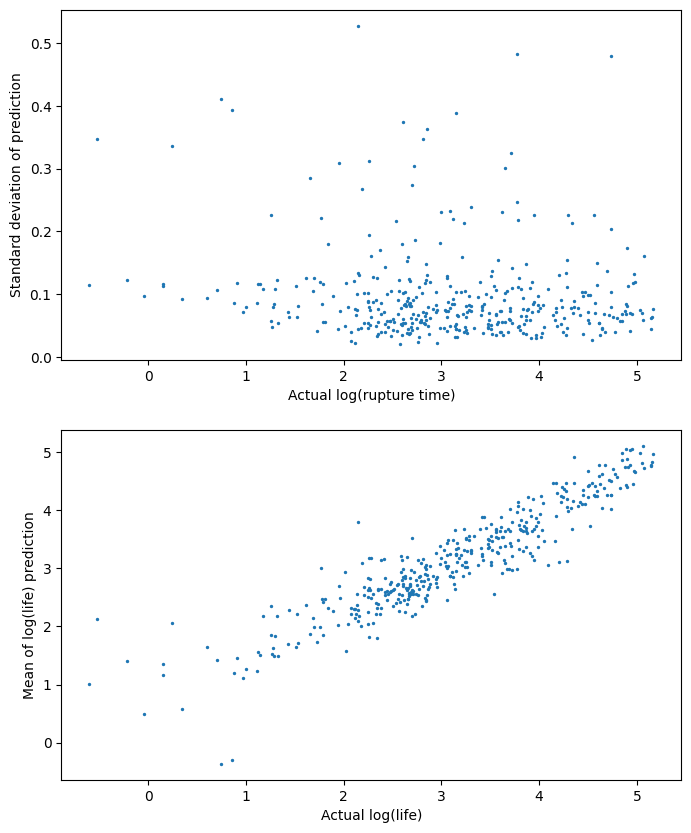

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(8,10))

bootY, bootMean, bootSTD, bootPredictions = bootstrapSVM(df2)

print(r2_score(bootY, bootMean))

ax[0].scatter(bootY,bootSTD,s=2)
ax[1].scatter(bootY,bootMean,s=2)

ax[0].set(xlabel='Actual log(rupture time)')
ax[0].set(ylabel='Standard deviation of prediction')

ax[1].set(xlabel='Actual log(life)')
ax[1].set(ylabel='Mean of log(life) prediction')


Out of interest, this is what the distribution of standard deviations looks like:

[Text(0.5, 0, 'Standard deviation of predictions'),
 Text(0, 0.5, 'Number of occurences')]

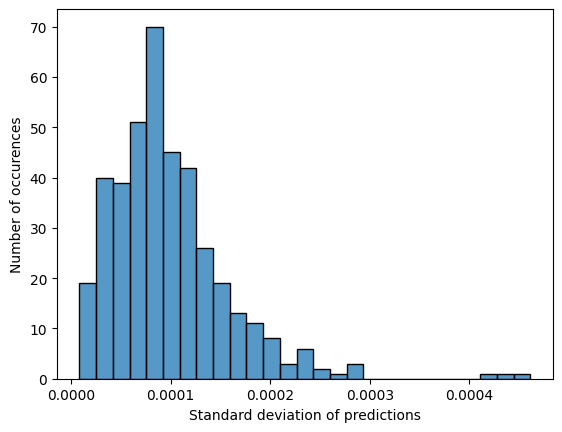

In [ ]:
import seaborn as sns
fig = sns.histplot(bootSTD)
fig.set(xlabel='Standard deviation of predictions',ylabel='Number of occurences')

Now to try to apply the data validation strategy. We'll normalize the residuals to the standard deviation of predictions, and those with a very large value are classified as potentially problematic.

The figure shows all the test points of ONE train/test split, colored in red if determined as faulty, and blue otherwise. The decision boundary here was arbitrarily set at 5, which yields about 1/5 of points determined as potentially faulty.

Text(0, 0.5, 'residuals (prediction - true value)')

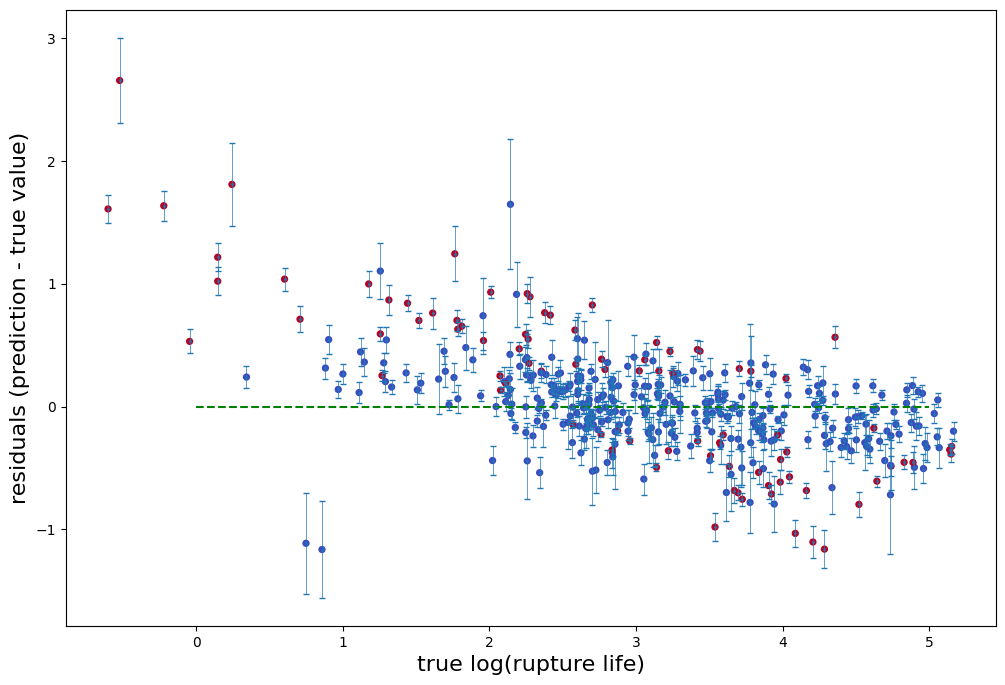

In [ ]:
residuals = bootMean-bootY
delta = residuals/bootSTD
classes = abs(delta)>5

plt.figure(figsize=(12,8))

plt.errorbar(bootY,bootMean-bootY,yerr=bootSTD, fmt='o', linestyle='None', capsize=2, linewidth=0.5, label='Error Bars', markersize=1)
plt.scatter(bootY,bootMean-bootY,c=classes,cmap="coolwarm",s=18)
plt.plot([0,5], [0,0], c = "green", linestyle = "--", label="ideal line")
plt.xlabel("true log(rupture life)", fontsize=16)
plt.ylabel("residuals (prediction - true value)", fontsize=16)

##4.4 Updated faulty data detection - iterative approach

In this section I have replicated the above, but with an iterative approach that goes through and classifies the entire dataset, rather than just the test subset from one specific train/test split. Importantly, points end up being assessed multiple times, and the final classification is taken as the average outcome (if a point is classified faulty 3 times and not faulty 2 times, then it ultimately is classified as faulty).

In [13]:
from sklearn.svm import SVR           #support vector regression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def bootstrapSVM(df):
  X = df.drop([time_variable, 'logtime', "Reference"], axis=1)
  y = df['logtime']

  scaler = StandardScaler()
  Xscaled = scaler.fit_transform(X)

  indices = list(range(len(Xscaled)))

  # Split the indices into training and testing sets
  train_indices, test_indices = train_test_split(indices, test_size=0.2)

  # Access the training data using the indices
  X_train = Xscaled[train_indices]
  y_train = y[train_indices]

  # Access the test data using the indices
  X_test = Xscaled[test_indices]
  y_test = y[test_indices]

  n_models = 25
  predictions = np.zeros((n_models, len(X_test)))

  for i in range(n_models):
      # Create a bootstrap sample
      X_train_boot, y_train_boot = resample(X_train, y_train)

      # Fit SVR model
      svr = SVR(kernel='rbf', C=100, epsilon=0.1)
      svr.fit(X_train_boot, y_train_boot)

      # Make predictions on the test set
      predictions[i, :] = svr.predict(X_test)

  # Calculate uncertainty (e.g., standard deviation)
  prediction_mean = np.mean(predictions, axis=0)
  prediction_std = np.std(predictions, axis=0)

  return test_indices, y_test.to_numpy(), prediction_mean, prediction_std

Here we put the above defined function into use:

In [36]:
N = df2.shape[0] #number of data points
results = [[] for _ in range(N)]
resids = [[] for _ in range(N)]
locs = [[] for _ in range(N)]
stds = [[] for _ in range(N)]

bootSTD = None
delta = None
y = None
prediction = None

for i in range(1,21):
  test_indices, y, prediction, bootSTD = bootstrapSVM(df2)
  delta = abs(y-prediction)/bootSTD
  classes = np.array(delta>5).astype(int)

  if i%5==0:
    print(f"iterations complete: {i}")

  for j in range(len(test_indices)):
    results[test_indices[j]].append(classes[j])
    resids[test_indices[j]].append(y[j]-prediction[j])
    locs[test_indices[j]].append(y[j])
    stds[test_indices[j]].append(bootSTD[j])

iterations complete: 5
iterations complete: 10
iterations complete: 15
iterations complete: 20


Below we save the average prediction and std for each point, so that we can plot them thereafter.

In [41]:
final_classes  = np.zeros((N,1))
final_resids = np.zeros((N,1))
final_locs = np.zeros((N,1))
final_stds = np.zeros((N,1))

for i in range(len(results)):
  if len(results[i]) == 0:
    continue
  else:
    final_classes[i] = round(np.mean(results[i]))
    final_resids[i] = np.mean(resids[i])
    final_locs[i] = np.mean(locs[i])
    final_stds[i] = np.mean(stds[i])


Converting the lists into a consistent format.

In [42]:
final_stds = np.array(final_stds).flatten()
final_locs = np.array(final_locs).flatten()
final_resids = np.array(final_resids).flatten()
final_classes = np.array(final_classes).flatten()

Out of curiosity, this is how many points are classified as faulty using the decision boundary of delta=5.

In [43]:
print(sum(final_classes))

79.0


This plot shows all the points in the dataset and the colors corresponding to their classification. Overall, the points with larger residuals appear to have larger uncertainties (shown by the error bars), which is generally positive. This implies that although models gave inaccurate predictions for these points, uncertainties convey a sense of uncertainty among the models.

Text(0, 0.5, 'residuals (prediction - true value)')

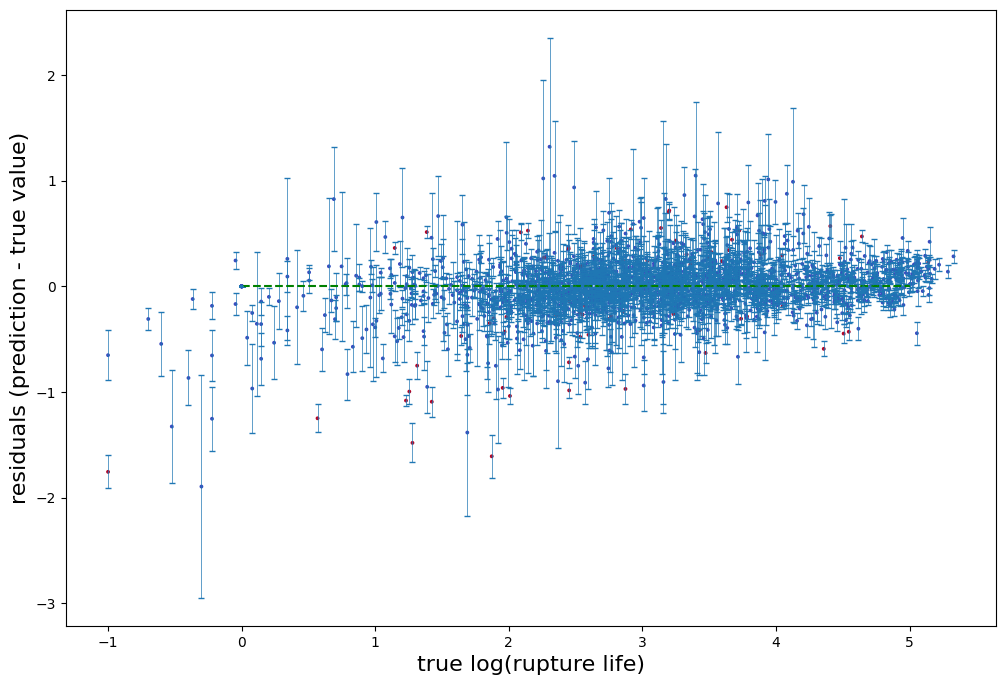

In [40]:
plt.figure(figsize=(12, 8))
plt.scatter(final_locs,final_resids, c=final_classes,s=3, cmap="coolwarm")
plt.errorbar(final_locs,final_resids, yerr=final_stds, fmt='o', linestyle='None', capsize=2, linewidth=0.5, label='Error Bars', markersize=0.2)
plt.plot([0,5], [0,0], c = "green", linestyle = "--", label="ideal line")
plt.xlabel("true log(rupture life)", fontsize=16)
plt.ylabel("residuals (prediction - true value)", fontsize=16)

# 5. Multi-Layer Perceptron (MLP)
Here we employ Scikit-Learn's MLP library.

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def train_MLP(df):
  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  X = Zscale(X)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Create an MLPRegressor model
  mlp = MLPRegressor(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001)

  # Train the model
  mlp.fit(X_train, y_train)

  # Make predictions on the test set
  test_pred = mlp.predict(X_test)
  train_pred = mlp.predict(X_train)

  #fine MSE
  test_mse = mean_squared_error(y_test, test_pred)
  train_mse = mean_squared_error(y_train,train_pred)

  #find r^2
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))

  plt.scatter(test_pred,y_test,s=3)
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  plt.show()

  return X_train, X_test, mlp, test_pred,y_test

Pretty sure the labels here are incorrect. I think it contains the right labels but at the wrong colors.

r^2 for test data: 0.8794765606931085
r^2 for training data: 0.9380098747027605
MSE for test data: 0.1269291565134768
MSE for training data: 0.06629540175785364


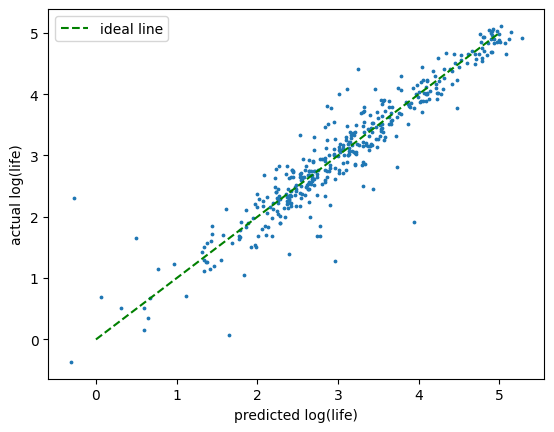

In [60]:
X_train, X_test, mlp, test_pred,y_test = train_MLP(df2)

## 5.1 MLP Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

def gridSearchMLP(df):
  X = df.drop([time_variable, 'logtime', 'Reference'], axis=1)
  y = df['logtime']
  X = Zscale(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  model = MLPRegressor()

  # Define the hyperparameter grid
  param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    }

  # Instantiate the GridSearchCV object
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

  # Fit the GridSearchCV object to the data
  grid_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_

  # Get the best model and make predictions on the test set
  best_model = grid_search.best_estimator_
  test_pred = best_model.predict(X_test)
  train_pred = best_model.predict(X_train)

  # Evaluate the performance of the best model
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train, train_pred)

  print(f"best params: {best_params}")
  print(f"test r2: {r2_test}")
  print(f"train r2: {r2_train}")

  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([0,5], [0,5], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")

  return best_model

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


best params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.001}
test r2: 0.8915012999424186
train r2: 0.9126901273474277


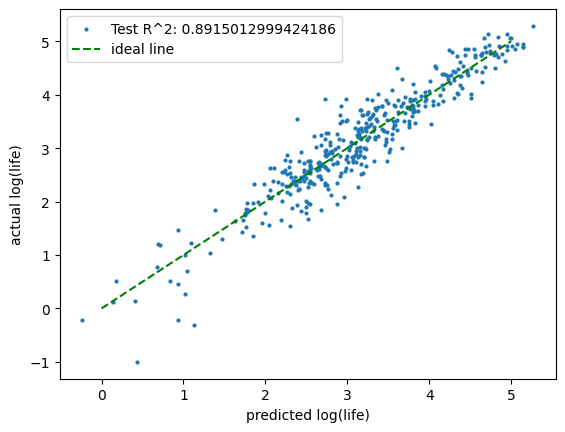

In [ ]:
bestMLP = gridSearchMLP(df2)

## 5.2 K-fold validation MLP

The usual K-fold validation of MLP model:

In [63]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

# Prepare the feature matrix X and the target vector y
X = df2.drop([time_variable, 'logtime', 'Reference'], axis=1)
X = Zscale(X)
y = df2['logtime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the number of folds
k_folds = 25

# Create a random forest classifier (replace this with your actual model)
classifier = MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.001)

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = cross_val_score(classifier, X, y, cv=kf, scoring='r2')

# Print the average accuracy across all folds
print(f'Average Accuracy: {np.mean(cv_results):.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Average Accuracy: 0.9255


Below is the implementation of successive feature addition. Feature importances are gathered from SHAP, and then models are trained with features added sucecssively to see how performances converge as the models approach the use of all input features.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

allItems = [t[0] for t in feature_importance_list[2:]]

for i in range(len(allItems)):

  testItems = ["Creep rupture stress (MPa)", "Temperature (°C)"] + allItems[:i]

  X = df2.drop([time_variable, 'logtime', 'N (%)'], axis=1)
  X = X.loc[:,testItems]
  X = Zscale(X)
  y = df2['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  # Define the number of folds
  k_folds = 15

  # Create a random forest classifier (replace this with your actual model)
  classifier = MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate_init=0.001)

  # Perform k-fold cross-validation
  kf = KFold(n_splits=k_folds, shuffle=True)

  # Store the cross-validation results
  cv_results = cross_val_score(classifier, X, y, cv=kf, scoring='r2')

  # Print the results for each fold
  #for j, accuracy in enumerate(cv_results, 1):
  #    print(f'Fold {j}: Accuracy = {accuracy:.4f}')

  # Print the average accuracy across all folds
  #print(f'Average Accuracy: {np.mean(cv_results):.4f}')

  if i>=1:
    print(f"item number {i} ({allItems[i-1]}) from allItems list. mean accuracy {np.mean(cv_results):.4f}")
  else:
    print(f"first iteration, just stress and temp, mean accuracy {np.mean(cv_results):.4f}")

first iteration, just stress and temp, mean accuracy 0.7342
item number 1 (Ni (%)) from allItems list. mean accuracy 0.7598


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 2 (Category_N&T) from allItems list. mean accuracy 0.7713


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 3 (Cu (%)) from allItems list. mean accuracy 0.8070


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 4 (C (%)) from allItems list. mean accuracy 0.8366


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 5 (S (%)) from allItems list. mean accuracy 0.8540


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 6 (Max Tempering Temperature (°C)) from allItems list. mean accuracy 0.9058


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 7 (Sn (%)) from allItems list. mean accuracy 0.9039


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 8 (Category_Q&T) from allItems list. mean accuracy 0.9096


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 9 (P (%)) from allItems list. mean accuracy 0.9176


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 10 (Si (%)) from allItems list. mean accuracy 0.9155


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 11 (Category_Ann) from allItems list. mean accuracy 0.9169


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 12 (Minimum Section Size (mm)) from allItems list. mean accuracy 0.9162


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

item number 13 (Category_Q&T&T) from allItems list. mean accuracy 0.9202


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 14 (Mn (%)) from allItems list. mean accuracy 0.9221


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 15 (Mo (%)) from allItems list. mean accuracy 0.9219


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 16 (Al (%)) from allItems list. mean accuracy 0.9246


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 17 (Cr (%)) from allItems list. mean accuracy 0.9221


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 18 (V (%)) from allItems list. mean accuracy 0.9239


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 19 (Category_Not Known) from allItems list. mean accuracy 0.9255


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 20 (Category_N&T&T) from allItems list. mean accuracy 0.9222


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 21 (Category_Ex Service) from allItems list. mean accuracy 0.9249


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


item number 22 (Category_PWHT) from allItems list. mean accuracy 0.9214


## 5.3 Uncertainty estimation with MLP

In [ ]:
from sklearn.neural_network import MLPRegressor          #multi layer perceptron
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def bootstrapMLP(df):
  X = df.drop(['Time to Rupture (hr)', 'logtime', 'Reference'], axis=1)
  y = df['logtime']

  scaler = StandardScaler()
  Xscaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2)

  n_models = 15
  predictions = np.zeros((n_models, len(X_test)))

  for i in range(n_models):
      # Create a bootstrap sample
      X_train_boot, y_train_boot = resample(X_train, y_train)

      # Fit SVR model
      mlp = MLPRegressor()
      mlp.fit(X_train_boot, y_train_boot)

      # Make predictions on the test set
      predictions[i, :] = mlp.predict(X_test)
      print(r2_score(y_test,predictions[i,:]))

  # Calculate uncertainty (e.g., standard deviation)
  prediction_mean = np.mean(predictions, axis=0)
  prediction_std = np.std(predictions, axis=0)

  return y_test, prediction_std, predictions

In [ ]:
bootMLP = bootstrapMLP(df2)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8235715471252242


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8120923602206986


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8286224962939508


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7971445398295007


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8198634826699951


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8181998169298133


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8216901409297211


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8197509600866631


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8055565123500101


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7694158967805752


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7883588798281294


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8042160199445325


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7826939651841623


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8018422977662553
0.8054445711209155


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0, 0.5, 'standard deviation of sample prediction')

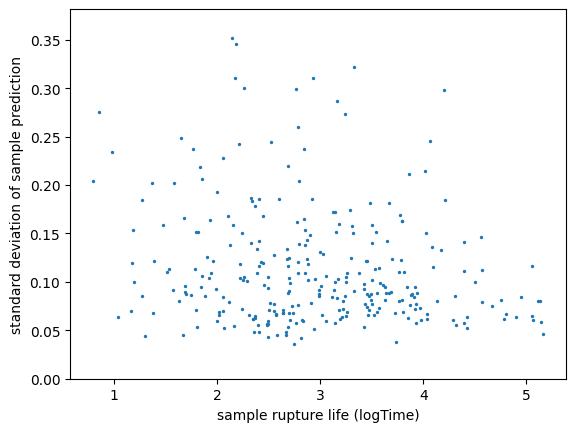

In [ ]:
import matplotlib.pyplot as plt

bootY, bootSTD, bootPredictions = bootMLP
plt.scatter(bootY,bootSTD,s=2)
plt.ylim((0,np.max(bootSTD)+0.03))
plt.xlabel("sample rupture life (logTime)")
plt.ylabel("standard deviation of sample prediction")

0.8263703759701077


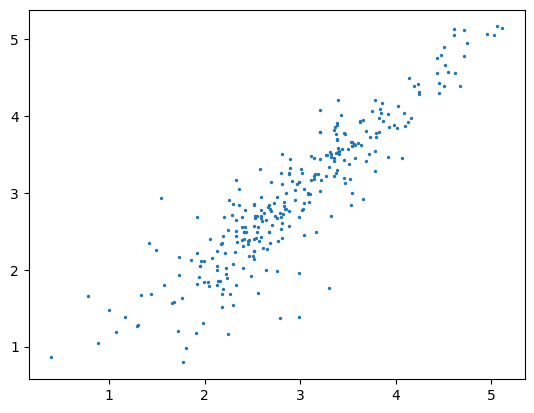

In [ ]:
plt.scatter(np.mean(bootPredictions, axis=0),bootY, s=2)
print(r2_score(bootY,np.mean(bootPredictions, axis=0)))

# 6. Keras NN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def create_model(input_dim):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=input_dim))
    model.add(Dense(90, activation='sigmoid'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer="adam", loss='mean_squared_error')
    return model


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def train_NN(df):
  #df = df[df['Time to Rupture (hr)'] >= 1]

  X = df.drop(['Time to Rupture (hr)', 'logtime'], axis=1)
  X = Zscale(X)
  y = df['logtime']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  NN = create_model(X.shape[1])

  NN.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=2)

  # Make predictions on the test set
  test_pred = NN.predict(X_test)
  train_pred = NN.predict(X_train)

  #assess prediction performance
  test_mse = mean_squared_error(y_test,test_pred)
  train_mse = mean_squared_error(y_train,train_pred)
  r2_test = r2_score(y_test, test_pred)
  r2_train = r2_score(y_train,train_pred)

  print("r^2 for test data: " + str(r2_test))
  print("r^2 for training data: " + str(r2_train))
  print("MSE for test data: " + str(test_mse))
  print("MSE for training data: " + str(train_mse))


  plt.scatter(test_pred,y_test, s=4, label=f"Test R^2: {r2_test}")
  plt.plot([min(test_pred), max(test_pred)], [min(test_pred), max(test_pred)], c = "green", linestyle = "--", label="ideal line")
  plt.legend()
  plt.xlabel("predicted log(life)")
  plt.ylabel("actual log(life)")
  return test_pred, y_test, NN

Epoch 1/150
51/51 - 2s - loss: 2.1585 - val_loss: 1.0898 - 2s/epoch - 34ms/step
Epoch 2/150
51/51 - 0s - loss: 0.9045 - val_loss: 0.9155 - 187ms/epoch - 4ms/step
Epoch 3/150
51/51 - 0s - loss: 0.7702 - val_loss: 0.7852 - 187ms/epoch - 4ms/step
Epoch 4/150
51/51 - 0s - loss: 0.6780 - val_loss: 0.7362 - 180ms/epoch - 4ms/step
Epoch 5/150
51/51 - 0s - loss: 0.5926 - val_loss: 0.6523 - 181ms/epoch - 4ms/step
Epoch 6/150
51/51 - 0s - loss: 0.5190 - val_loss: 0.5828 - 182ms/epoch - 4ms/step
Epoch 7/150
51/51 - 0s - loss: 0.4459 - val_loss: 0.5049 - 177ms/epoch - 3ms/step
Epoch 8/150
51/51 - 0s - loss: 0.3991 - val_loss: 0.4544 - 180ms/epoch - 4ms/step
Epoch 9/150
51/51 - 0s - loss: 0.3385 - val_loss: 0.4102 - 182ms/epoch - 4ms/step
Epoch 10/150
51/51 - 0s - loss: 0.2973 - val_loss: 0.3833 - 182ms/epoch - 4ms/step
Epoch 11/150
51/51 - 0s - loss: 0.2870 - val_loss: 0.3442 - 176ms/epoch - 3ms/step
Epoch 12/150
51/51 - 0s - loss: 0.2510 - val_loss: 0.3175 - 180ms/epoch - 4ms/step
Epoch 13/150
51

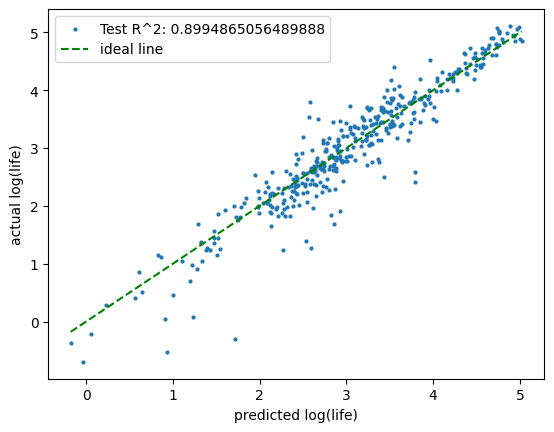

In [ ]:
pred, y, NN = train_NN(df2)

## 6.1 Keras residuals analysis

In [ ]:
def plotResiduals(df, model):
  fig, ax = plt.subplots(1, 2, figsize=(12,5))

  #df = df[df['Time to Rupture (hr)'] >= 1]
  X = df.drop(['Time to Rupture (hr)', 'logtime'], axis=1)
  X = Zscale(X)
  y = df['logtime']

  y_pred = model.predict(X).flatten()

  residuals = y-y_pred
  ax[0].scatter(y,residuals/y,s=1)
  ax[0].set_xlabel('actual logtime')
  ax[0].set_ylabel('relative error of predicted logtime')

  yt = 10**y
  yt_pred = 10**y_pred
  residuals = yt - yt_pred
  relative_res = residuals/yt

  ax[1].scatter(yt,relative_res, s=1)
  ax[1].set_xlabel('actual rupture time')
  ax[1].set_ylabel('relative error of predicted rupture time')

63/63 [==============================] - 0s 2ms/step


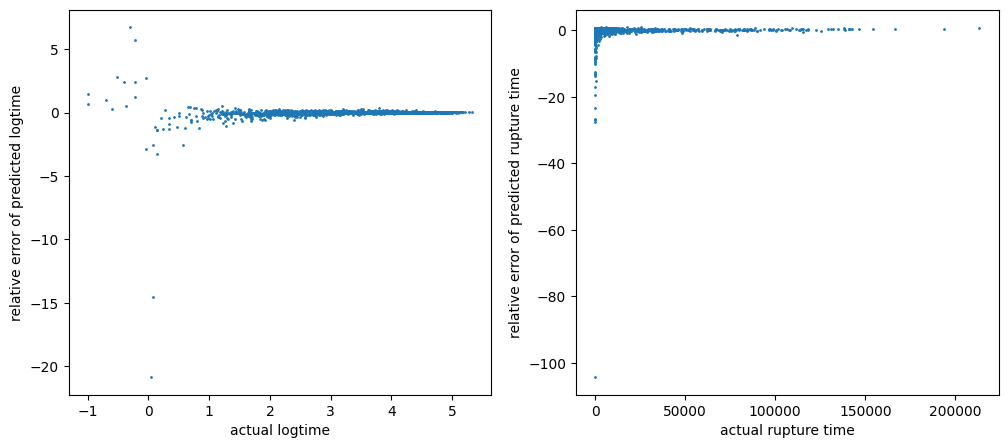

In [ ]:
plotResiduals(df2,NN)

## 6.2. K-fold validation Keras NN

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense

X = df2.drop(['Time to Rupture (hr)', 'logtime', 'Reference'], axis=1)
X = Zscale(X)
y = df2['logtime']

# Define the number of folds
k_folds = 10

# Create a function to build the Keras model
def build_model():
  model = Sequential()
  model.add(Dense(16, activation='relu', input_dim=22))
  model.add(Dense(70, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(90, activation='sigmoid'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer="adam", loss='mean_squared_error')
  return model

# Perform k-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True)

# Store the cross-validation results
cv_results = []

model = build_model()

for train_index, val_index in kf.split(X):
  model = build_model()
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

  model.fit(X_train,y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), verbose=0)

  # Predict on the validation data
  y_pred = model.predict(X_val)

  # Calculate mean squared error for this fold
  r2 = r2_score(y_val, y_pred)

  cv_results.append(r2)

# Print the results for each fold
for i, r2 in enumerate(cv_results, 1):
    print(f'Fold {i}: R^2 = {r2:.4f}')

# Print the average mean squared error across all folds
print(f'Average R^2: {np.mean(cv_results):.4f}')

5/5 [==============================] - 0s 2ms/step
Fold 1: R^2 = 0.8021
Fold 2: R^2 = 0.8754
Fold 3: R^2 = 0.8708
Fold 4: R^2 = 0.8721
Fold 5: R^2 = 0.8672
Fold 6: R^2 = 0.8475
Fold 7: R^2 = 0.8968
Fold 8: R^2 = 0.8372
Fold 9: R^2 = 0.9121
Fold 10: R^2 = 0.8339
Average R^2: 0.8615


# 7. Ensemble Methods

## 7.1. Voting Regression

In [ ]:
from sklearn.svm import SVR           #support vector regression
from sklearn.neural_network import MLPRegressor as MLP
from xgboost.sklearn import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def votingRegression(df):
  X = df.drop([time_variable, 'logtime'], axis=1)
  y = df['logtime']

  scaler = StandardScaler()
  Xscaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2)

  n_models = 4
  predictions = np.zeros((n_models*4, len(X_test)))

  for i in range(n_models*4):
      # Create a bootstrap sample
      X_train_boot, y_train_boot = resample(X_train, y_train)

      if i%n_models==0:
        modelName = "SVR"
        model = SVR(kernel='rbf', C=100, epsilon=0.2)
      elif i%n_models==1:
        modelName = "MLP"
        model = MLP(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001)
      elif i%n_models==2:
        modelName = "RF"
        model = RF(n_estimators=200,max_depth=None,min_samples_split=5,min_samples_leaf=1)
      elif i%n_models==3:
        modelName = "XGBR"
        model = XGBR(objective='reg:squarederror', colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200, subsample=0.9)

      print(f"model selected: {modelName}.")
      print(f"fitting {modelName} model to data...")
      model.fit(X_train_boot, y_train_boot)

      # Make predictions on the test set
      print("making predictions on test data...")
      predictions[i, :] = model.predict(X_test)
      print(f"Test data r^2 of {modelName} model: " + str(r2_score(y_test,predictions[i,:])))
      print("")

  # Calculate uncertainty (e.g., standard deviation)
  prediction_mean = np.mean(predictions, axis=0)
  prediction_std = np.std(predictions, axis=0)

  return y_test, prediction_mean, prediction_std, predictions

In [ ]:
results = votingRegression(df2)

model selected: SVR.
fitting SVR model to data...
making predictions on test data...
Test data r^2 of SVR model: 0.9169786061447162

model selected: MLP.
fitting MLP model to data...
making predictions on test data...
Test data r^2 of MLP model: 0.871581764628512

model selected: RF.
fitting RF model to data...
making predictions on test data...
Test data r^2 of RF model: 0.8184174839967153

model selected: XGBR.
fitting XGBR model to data...
making predictions on test data...
Test data r^2 of XGBR model: 0.8794310766915913

model selected: SVR.
fitting SVR model to data...
making predictions on test data...
Test data r^2 of SVR model: 0.9267036718850109

model selected: MLP.
fitting MLP model to data...
making predictions on test data...
Test data r^2 of MLP model: 0.8788963725477399

model selected: RF.
fitting RF model to data...
making predictions on test data...
Test data r^2 of RF model: 0.8280135722648719

model selected: XGBR.
fitting XGBR model to data...
making predictions on

0.926473648530017


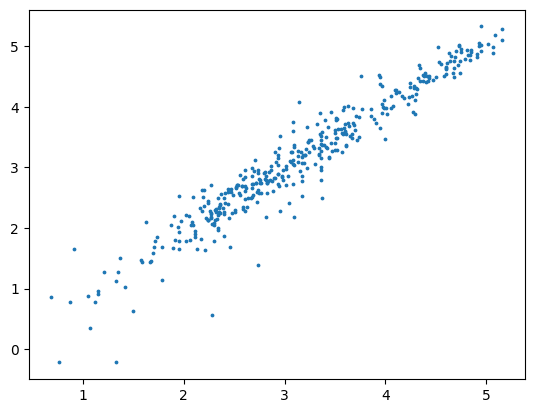

In [ ]:
plt.scatter(results[1],results[0], s=3)
print(r2_score(results[0],results[1]))

K fold validation of Voting Regression:

In [ ]:
k = 10
performs = []
for i in range(k):
  y_test,pred_mean,_,_ = votingRegression(df2)
  performs.append(r2_score(y_test, pred_mean))

print(performs)
print(np.mean(performs))

model selected: SVR.
fitting SVR model to data...
making predictions on test data...
Test data r^2 of SVR model: 0.8968472505102265

model selected: MLP.
fitting MLP model to data...
making predictions on test data...
Test data r^2 of MLP model: 0.8828944392508162

model selected: RF.
fitting RF model to data...
making predictions on test data...
Test data r^2 of RF model: 0.7987220470126434

model selected: XGBR.
fitting XGBR model to data...
making predictions on test data...
Test data r^2 of XGBR model: 0.8893762578083113

model selected: SVR.
fitting SVR model to data...
making predictions on test data...
Test data r^2 of SVR model: 0.8846449287454863

model selected: MLP.
fitting MLP model to data...
making predictions on test data...
Test data r^2 of MLP model: 0.8458137123003373

model selected: RF.
fitting RF model to data...
making predictions on test data...
Test data r^2 of RF model: 0.8116317271270325

model selected: XGBR.
fitting XGBR model to data...
making predictions o

##7.2. Stacking (Meta-modeling)
Here we use RF as the meta model, with initial models being SVR MLP, and XGBR

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as MLP
from xgboost.sklearn import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge as RR
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def train_stack2(df):

  X = df.drop([time_variable, 'logtime'], axis=1)
  y = df['logtime']

  scaler = StandardScaler() #scale input features
  Xscaled = scaler.fit_transform(X)

  X_train, X_testCombined, y_train, y_testCombined = train_test_split(Xscaled, y, test_size=0.2) #initial train test split
  X_test, X_val, y_test, y_val = train_test_split(X_testCombined, y_testCombined, test_size=0.4) #test data is further split into test and validation (test is to train stack model)

  #initialize the initial models that will be used:
  svr = SVR(kernel='rbf', C=100, epsilon=0.2)
  mlp = MLP(activation='relu', alpha=0.0001, hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.001)
  #rf = RF(n_estimators=200,max_depth=None,min_samples_split=5,min_samples_leaf=1)
  xgbr = XGBR(objective='reg:squarederror', colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200, subsample=0.9)

  #train models on the initial training data:
  svr.fit(X_train, y_train)
  mlp.fit(X_train, y_train)
  #rf.fit(X_train, y_train)
  xgbr.fit(X_train, y_train)

  #make predictions on test data using initial models:
  SVRpred = svr.predict(X_test)
  MLPpred = mlp.predict(X_test)
  #RFpred = rf.predict(X_test)
  XGBRpred = xgbr.predict(X_test)

  #print model performances
  print(f"svr performance: {r2_score(y_test,SVRpred)}")
  print(f"MLP performance: {r2_score(y_test,MLPpred)}")
  #print(f"RF performance: {r2_score(y_test,RFpred)}")
  print(f"XGBR performance: {r2_score(y_test,XGBRpred)}")

  #join up the predictions, each row being one sample, with the columns being the predictions using the different models, as well as the real value.
  stackData = pd.DataFrame({'SVR Prediction': SVRpred, 'MLP Prediction': MLPpred, 'XGBR Prediction': XGBRpred, 'Real y': y_test}) #'RF Prediction': RFpred,

  #get X and y from this to train the stack model
  stackX = stackData.drop(['Real y'], axis=1)
  stackY = stackData.loc[:,'Real y']

  #standard scaling these new input features
  stackScaler = StandardScaler()
  stackX = stackScaler.fit_transform(stackX)

  #initialize our meta model and fit it to the training data
  stackModel = LR()
  stackModel.fit(stackX,stackY)

  #return the models so they can be used later, as well as the data we are testing on (val) and the stack scaler.
  return svr,mlp,xgbr,stackModel,X_val,y_val,stackScaler #,rf

def stack_predict2(svr,mlp,xgbr,stackModel,X_val,y_val,stackScaler): #rf,
  #load the models and make predictions on our input data, which comes from our test/train/val split above
  #this function can be adjusted slighlty to take fully new data as well (with no corresponding output).
  SVRpred = svr.predict(X_val)
  MLPpred = mlp.predict(X_val)
  #RFpred = rf.predict(X_val)
  XGBRpred = xgbr.predict(X_val)

  #join up these predictions
  stackPreds = pd.DataFrame({'SVR Prediction': SVRpred, 'MLP Prediction': MLPpred, 'XGBR Prediction': XGBRpred, 'Real y': y_val}) # 'RF Prediction': RFpred,

  X = stackPreds.drop(['Real y'], axis=1)
  y = stackPreds.loc[:,'Real y']

  #find means before scaling
  ave_preds_final = np.mean(X,axis=1)

  #once again scale the features, since our stack model is trained on scaled features
  X = stackScaler.transform(X)
  stack_preds_final = stackModel.predict(X)

  plt.scatter(stack_preds_final,y,s=3)
  print(f'stack model score: {r2_score(y,stack_preds_final)}')
  print(f'stack average score: {r2_score(y,ave_preds_final)}')
  return stack_preds_final, ave_preds_final, y


In [ ]:
svr,mlp,xgbr,stackModel,X_val,y_val,scale1 = train_stack2(df2) #,rf

svr performance: 0.9648766760136371
MLP performance: 0.9778926228678841
XGBR performance: 0.9721850255460027


stack model score: 0.968170502303377
stack average score: 0.9677110110322418


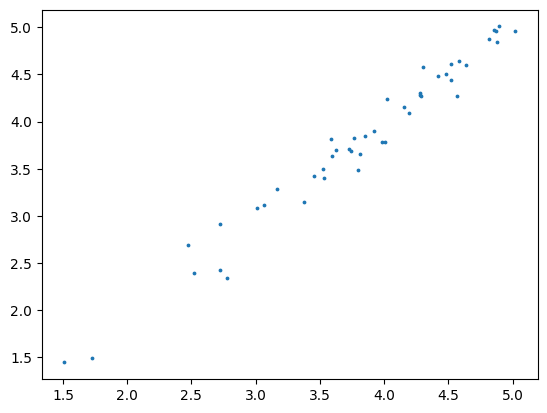

In [ ]:
stack_preds, ave_preds, y = stack_predict2(svr,mlp,xgbr,stackModel,X_val,y_val,scale1) #rf,

0.9233674348304078


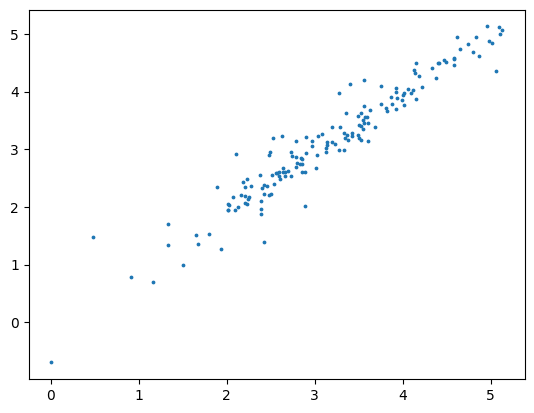

In [ ]:
plt.scatter(ave_preds,y,s=3)
print(r2_score(y,ave_preds))

iteration: 0
svr performance: 0.9314405102530323
MLP performance: 0.9026917098904264
XGBR performance: 0.8993725421981756
stack model score: 0.93083654818306
stack average score: 0.9406769738112837

iteration: 1
svr performance: 0.9184174291550296
MLP performance: 0.8813081068144022
XGBR performance: 0.8945582164720974
stack model score: 0.923852516256958
stack average score: 0.9104984943256925

iteration: 2
svr performance: 0.9067200010614032
MLP performance: 0.8545180525399307
XGBR performance: 0.9076449821493645
stack model score: 0.9419723932683906
stack average score: 0.9372170975941218

iteration: 3
svr performance: 0.9209511477016527
MLP performance: 0.8928639904661624
XGBR performance: 0.8897116271989967
stack model score: 0.9209110196737639
stack average score: 0.9262345548595319

iteration: 4
svr performance: 0.9083217854146359
MLP performance: 0.913229806194435
XGBR performance: 0.9018019901149602
stack model score: 0.9102438453720704
stack average score: 0.915320771985791



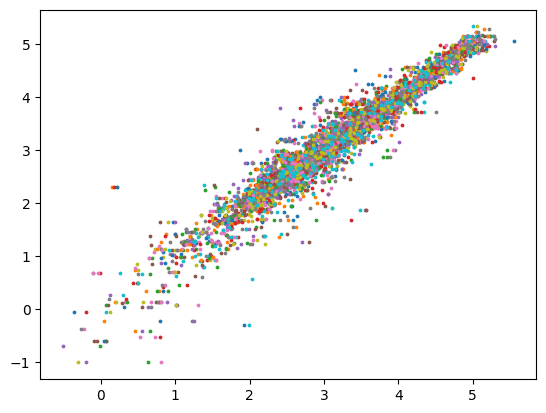

In [ ]:
performsModel = []
performsAvg = []
for i in range(30):
  print(f'iteration: {i}')
  svr, mlp, xgbr, stackModel, X_val, y_val, scaler = train_stack2(df2) # rf,
  stack_preds, ave_preds, y = stack_predict2(svr, mlp, xgbr, stackModel, X_val, y_val, scaler) # rf,
  performsModel.append(r2_score(y, stack_preds))
  performsAvg.append(r2_score(y, ave_preds))
  print('')

print(np.mean(performsModel))
print(np.mean(performsAvg))